# KTR Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_ktr_lev_knots
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

date_col = 'date'
response_col = 'electricity'

df[response_col] = np.log(df[response_col])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
# df = pd.read_csv("./data/melbourne-daily-min-temperatures.csv", parse_dates=['Date'])
# date_col = 'Date'
# response_col = 'Temp'
# df[response_col] = np.log(1 + df[response_col])
# df.head()

In [6]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [7]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [8]:
# level_knot_dates = pd.date_range(start='1981-01-01', end='1990-12-31', periods=21)
# level_knot_dates

In [9]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.5,
    span_level=.1,
    # level_knot_dates=level_knot_dates,
    # date_freq='D',
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)

In [10]:
ktrlite.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_881c766b9f6815a4c70ed9a2953ca015 NOW.


In [11]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction,trend,seasonality_7,seasonality_365.25
0,2008-01-02,9.99031,9.98083,0.02537,-0.01589
1,2008-01-03,9.99101,9.98083,0.02685,-0.01666
2,2008-01-04,10.00346,9.98083,0.03983,-0.01720
3,2008-01-05,9.93272,9.98083,-0.03062,-0.01749
4,2008-01-06,9.87734,9.98083,-0.08595,-0.01754


In [12]:
smape(predicted_df['prediction'].values, test_df['electricity'].values)

0.005620898897191989

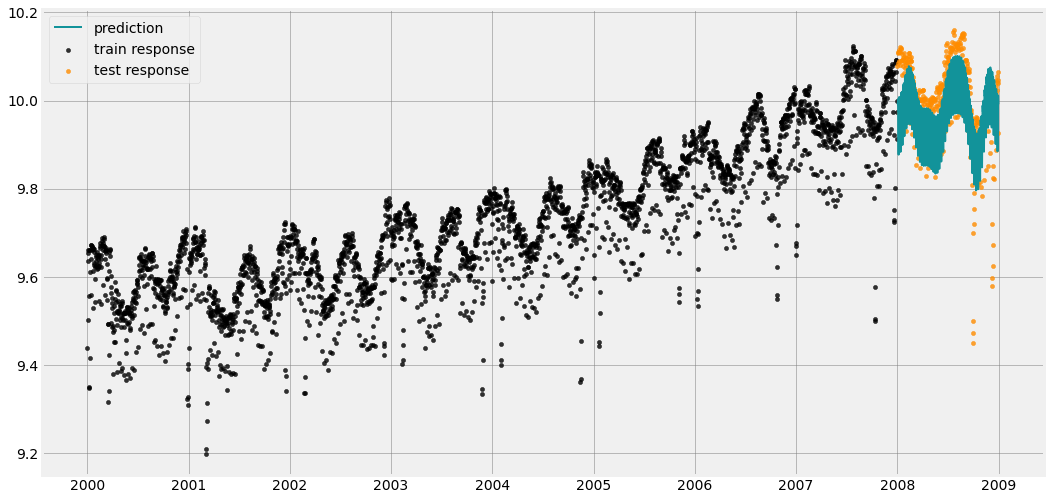

In [13]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df)

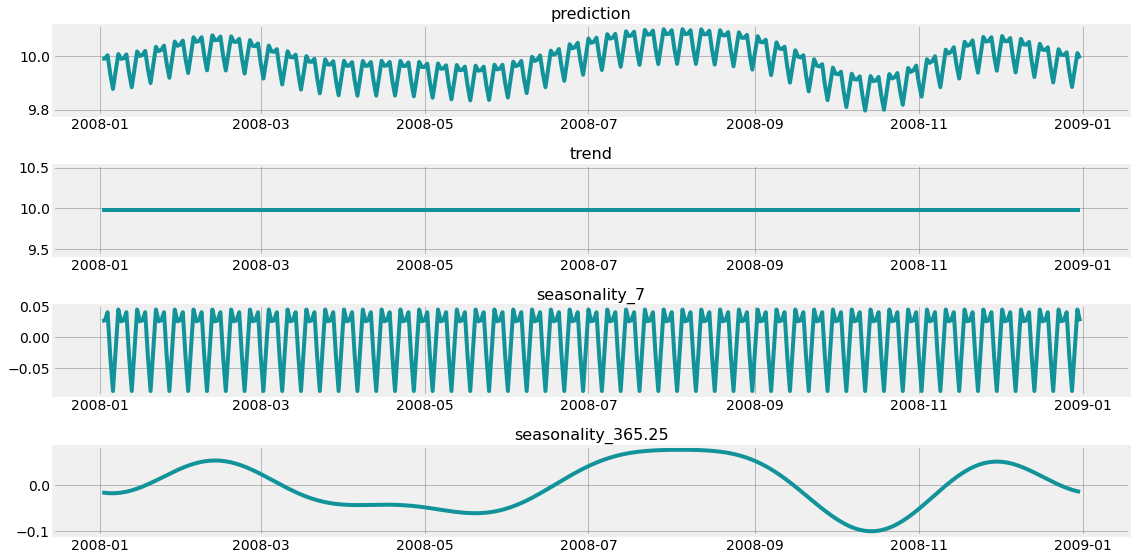

In [14]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                          plot_components=['prediction', 'trend', 'seasonality_7', 'seasonality_365.25'])

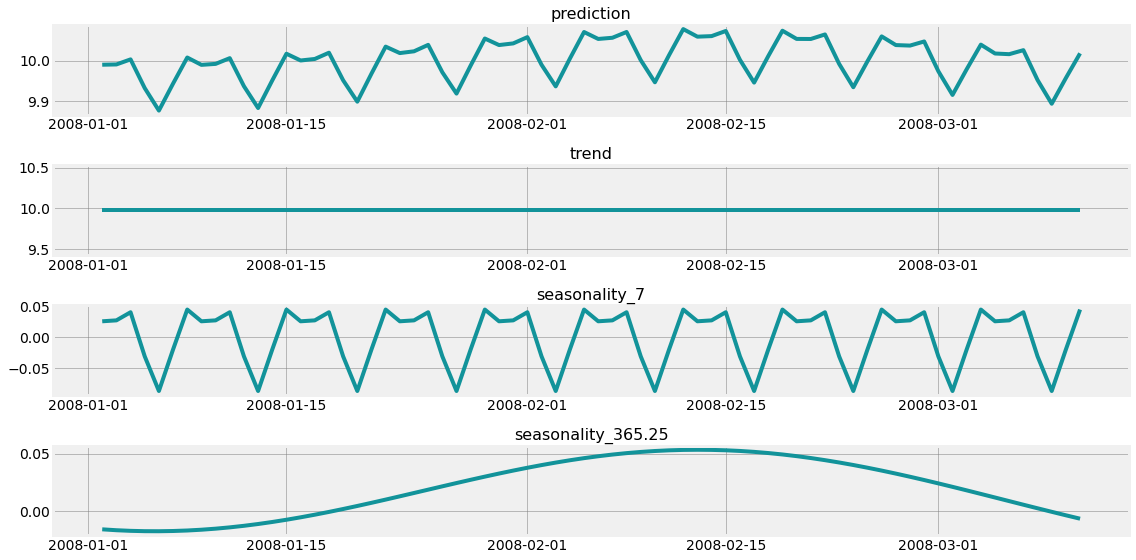

In [15]:
# zoom in
_ = plot_predicted_components(predicted_df=predicted_df[:70], date_col=date_col, 
                          plot_components=['prediction', 'trend', 'seasonality_7', 'seasonality_365.25'])

In [16]:
# get the knots
lev_knots = ktrlite._aggregate_posteriors['map']['lev_knot']
lev_knots_tp_discrete = ktrlite._knots_tp_level * train_df.shape[0] - 1
td = pd.Series([pd.Timedelta(days=k) for k in lev_knots_tp_discrete])
lev_knot_dates = train_df[date_col].iloc[0] + td

full_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
decomp_df = ktrlite.predict(df=full_df, decompose=True)

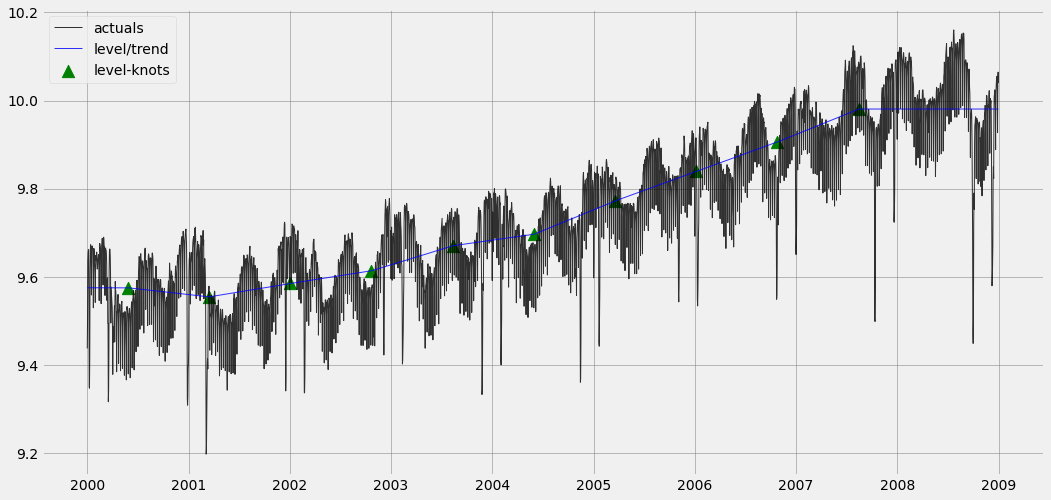

In [17]:
_ = plot_ktr_lev_knots(full_df, decomp_df, date_col, response_col, lev_knot_dates, lev_knots)

## KTRX

In [18]:
level_knot_dates = ktrlite._level_knot_dates
level_knots = ktrlite._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktrlite._coef_knot_dates,
    '_sea_coef_knot': ktrlite._aggregate_posteriors['map']['coef_knot'],
    '_sea_rho': ktrlite.rho_coefficients,
    '_seasonality': ktrlite._seasonality,
    '_seasonality_fs_order': ktrlite._seasonality_fs_order,
}

In [21]:
ktrx = KTRXAggregated(
    response_col=response_col,
    date_col=date_col,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    #regressor_col=
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=False,
    message=100,
    aggregate_method="median",
    estimator_type=PyroEstimatorVI,
)

ktrx.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [22]:
predicted_df = ktrx.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction,trend,seasonality_input,regression
0,2008-01-02,9.98987,9.98039,0.00948,0.00000
1,2008-01-03,9.99058,9.98039,0.01018,0.00000
2,2008-01-04,10.00303,9.98039,0.02263,0.00000
3,2008-01-05,9.93229,9.98039,-0.04811,0.00000
4,2008-01-06,9.87691,9.98039,-0.10349,0.00000


In [23]:
smape(predicted_df['prediction'].values, test_df['electricity'].values)

0.005643093002710255

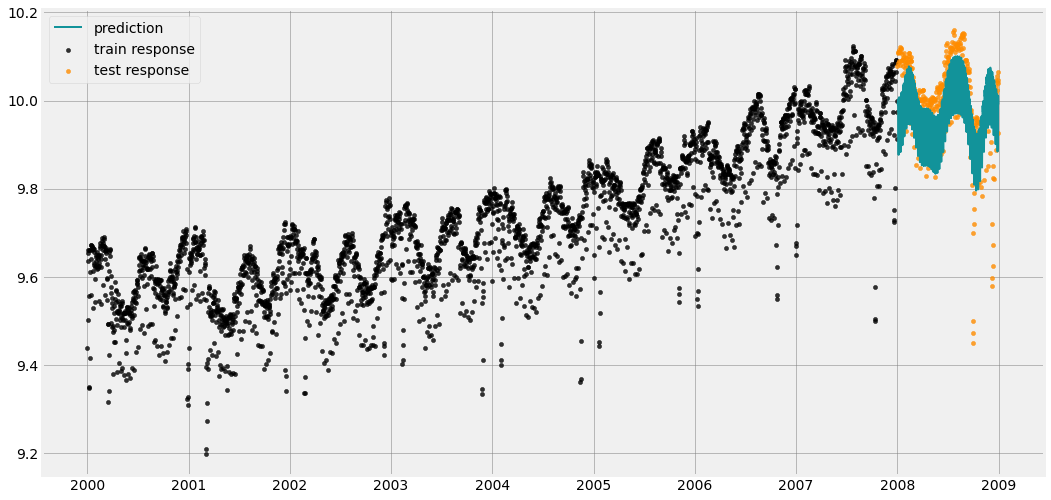

In [24]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df)

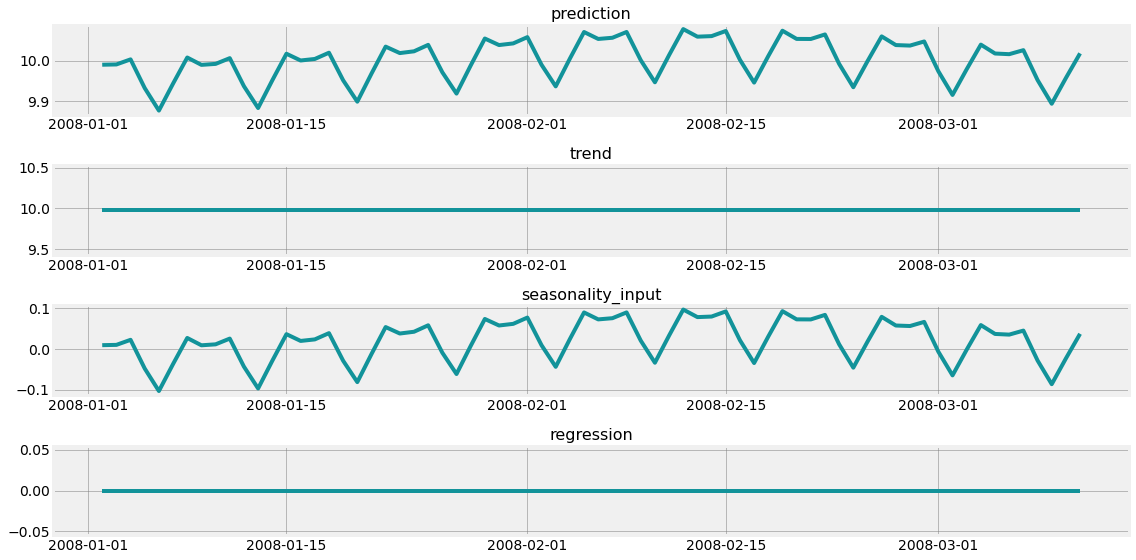

In [27]:
# zoom in
_ = plot_predicted_components(predicted_df=predicted_df[:70], date_col=date_col, 
                          plot_components=['prediction', 'trend', 
                                           'seasonality_input',
                                           'regression'])